# 分类器：按国别分类人名
> 原文：https://docs.pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
> 
> 本篇笔记用更简洁和现代的 API 重新实现原文的分类器，并实现更好的性能。

In [1]:
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

torch.manual_seed(9527)

## 1. 数据理解

`data/names/{nation}.txt` 有多个 txt 文件，文件名为国别标签，文件内容每行为一个名字。现把原始数据按文件读出，初步统计国别、名字及字符规模。

In [2]:
nation2names, charset = {}, set()

for path in glob("data/names/*.txt"):
    nation = path.split("/")[-1].split(".")[0]
    with open(path, "r", encoding="utf-8") as f:
        names = [name.strip() for name in f.readlines() if name.strip()]
        nation2names[nation] = names
        charset.update(*names)

nations = list(nation2names)
chars = "".join(sorted(charset))

vocab_size, label_size = len(chars) + 1, len(nations)

label_size, vocab_size, sum(len(names) for names in nation2names.values())

(18, 88, 20074)

## 2. 模型设计

1. 字符 one-hot 编码，输入 name 表示成张量 `(len(name), vocab_size)`
2. 标签 nation 表示成标量 `nations.index(nation)`
3. `(len(name), vocab_size)` -> RNN -> `(hidden_size)` -> Linear -> `(label_size)`

In [3]:
class Classifier(nn.Module):
    def __init__(self, vocab_size, hidden_size, label_size):
        super().__init__()
        self.rnn = nn.RNN(vocab_size, hidden_size)
        self.lin = nn.Linear(hidden_size, label_size)

    def forward(self, x, h=None):
        _, h = self.rnn(x, h)
        y = self.lin(h[-1])
        return y


model = Classifier(vocab_size, 128, label_size)
model

Classifier(
  (rnn): RNN(88, 128)
  (lin): Linear(in_features=128, out_features=18, bias=True)
)

## 3. 数据准备

1. 实现 name one hot 编码，不在字符集的字符编号为 `0`
2. 实现 Dataset 和 DataLoader, batch_size 为 32
3. 按 8:2 将数据集拆分为训练集和测试集

In [4]:
def one_hot_encode(text):
    indices = [chars.find(c) + 1 for c in text]
    return F.one_hot(torch.tensor(indices), vocab_size).float()


class Dataset(Dataset):
    def __init__(self, nation2names):
        self.data = []
        for nation, names in nation2names.items():
            for name in names:
                x = one_hot_encode(name)
                y = torch.tensor(nations.index(nation))
                self.data.append((x, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


batch_size, dataset = 32, Dataset(nation2names)
train_data, test_data = random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)
dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=lambda x: x)

for batch in dataloader:
    for x, y in batch:
        print(x.shape, y)
        break
    break

torch.Size([5, 88]) tensor(6)


## 4. 模型训练

1. 损失函数用 nn.CrossEntropyLoss
2. 优化器用 optim.Adam

Epoch  1/10, Loss: 1.3936080948052654
Epoch  2/10, Loss: 0.9967386676851971
Epoch  3/10, Loss: 0.8704388352682391
Epoch  4/10, Loss: 0.8045162478409915
Epoch  5/10, Loss: 0.749279522622724
Epoch  6/10, Loss: 0.7081978633346786
Epoch  7/10, Loss: 0.6726777807353027
Epoch  8/10, Loss: 0.6440303320606866
Epoch  9/10, Loss: 0.6141311557169454
Epoch 10/10, Loss: 0.5867926691810923


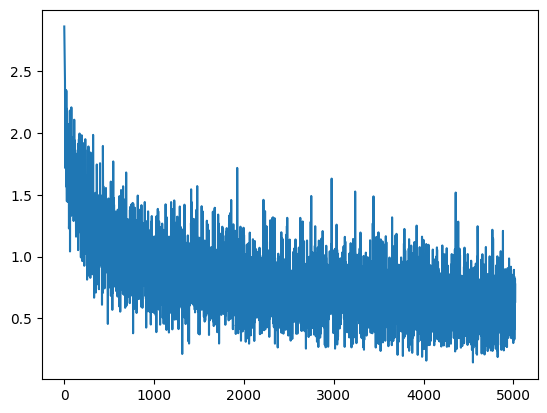

In [5]:
def train(epochs, model, dataloader, optimizer, loss_fn):
    optimizer.zero_grad(), model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            outputs, targets = [], []
            for x, y in batch:
                output = model(x)
                outputs.append(output)
                targets.append(y)

            outputs = torch.stack(outputs)
            targets = torch.stack(targets)
            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = loss.item()
            losses.append(loss)
            total_loss += loss
        print(f"Epoch {epoch+1:>2}/{epochs}, Loss: {total_loss / len(dataloader)}")
    return losses


optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

losses = train(10, model, dataloader, optimizer, loss_fn)

plt.figure()
plt.plot(losses)
plt.show()

## 5. 模型验证

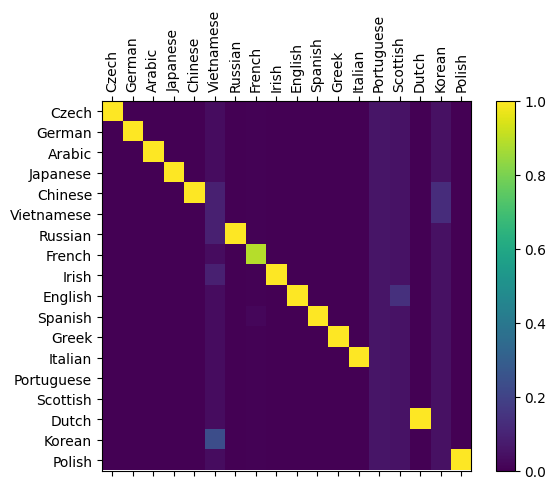

In [6]:
def eval(model, dataloader, label_size):
    model.eval()
    confusion = torch.zeros(label_size, label_size, dtype=torch.float)

    with torch.no_grad():
        for x, y in dataloader:
            output = model(x).argmax(dim=0)
            confusion[y][output] += 1
    return confusion


confusion = eval(model, DataLoader(test_data, batch_size=None), label_size)

confusion = torch.softmax(confusion, dim=0)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.cpu().numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticks(np.arange(label_size), labels=nations, rotation=90)
ax.set_yticks(np.arange(label_size), labels=nations)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()